In [73]:
from planet4 import io, region_data, markings
from p4_tools import get_final_markings_counts
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.optimize import root, curve_fit, leastsq

defining input: _input_ is a list of filenames as strings ('filename.csv'). _input_ can contain information for one or more regions. For 1 region, _input_ should contain that region's fan file, followed by the season 2 metadata for that region, followed by the season 3 metadata for that region, followed by that region's blotches file. For more than 1 region, add more filenames in the same order. A few definitions of _input_ are commented out for convenience.

In [74]:
_input_ = ['giza_fans.csv','giza_season2_metadata.csv','giza_season3_metadata.csv','giza_blotches.csv']
#_input_ = ['Inca_seasons23_fans.csv','inca_season2_metadata.csv','inca_season3_metadata.csv','Inca_seasons23_blotches.csv']
#_input_ = ['ithaca_fans.csv','ithaca_season2_metadata.csv','ithaca_season3_metadata.csv','ithaca_blotches.csv']
#_input_ = ['manhattan_fans.csv','manhattan_season2_metadata.csv','manhattan_season3_metadata.csv','manhattan_blotches.csv']
#_input_ = ['giza_fans.csv','giza_season2_metadata.csv','giza_season3_metadata.csv','giza_blotches.csv','Inca_seasons23_fans.csv','inca_season2_metadata.csv','inca_season3_metadata.csv','Inca_seasons23_blotches.csv','ithaca_fans.csv','ithaca_season2_metadata.csv','ithaca_season3_metadata.csv','ithaca_blotches.csv','manhattan_fans.csv','manhattan_season2_metadata.csv','manhattan_season3_metadata.csv','manhattan_blotches.csv']

get_regions creates a dataframe to help step through the processes below. note that fan and blotch file names must be identical to the ones following these "if" statements for the function to recognize them properly

In [75]:
def get_regions(_input_):
    regions = np.zeros((4,(len(_input_)//4)))
    regions = pd.DataFrame(regions)
    for i in range(len(_input_)//4):
        if _input_[i*4]=='giza_fans.csv':
            regions.loc[0,i] = _input_[i*4]
            regions.loc[1,i] = _input_[i*4+1]
            regions.loc[2,i] = _input_[i*4+2]
            regions.loc[3,i] = _input_[i*4+3]
            regions.loc[4,i] = 'Giza'
        elif _input_[i*4]=='Inca_seasons23_fans.csv':
            regions.loc[0,i] = _input_[i*4]
            regions.loc[1,i] = _input_[i*4+1]
            regions.loc[2,i] = _input_[i*4+2]
            regions.loc[3,i] = _input_[i*4+3]
            regions.loc[4,i] = 'Inca City'
        elif _input_[i*4]=='ithaca_fans.csv':
            regions.loc[0,i] = _input_[i*4]
            regions.loc[1,i] = _input_[i*4+1]
            regions.loc[2,i] = _input_[i*4+2]
            regions.loc[3,i] = _input_[i*4+3]
            regions.loc[4,i] = 'Ithaca'
        elif _input_[i*4]=='manhattan_fans.csv':
            regions.loc[0,i] = _input_[i*4]
            regions.loc[1,i] = _input_[i*4+1]
            regions.loc[2,i] = _input_[i*4+2]
            regions.loc[3,i] = _input_[i*4+3]
            regions.loc[4,i] = 'Manhattan'
    return regions

regions = get_regions(_input_)

begin loop through regions dataframe (if info on only 1 region is desired, this will not loop): find unique images, split according to season, arrange according to increasing L_s, define minimum fan length and blotch area

In [76]:
for i in range((len(_input_)//4)):
    s2_meta = pd.read_csv(regions[i][1])
    s3_meta = pd.read_csv(regions[i][2])
    fans = pd.read_csv(regions[i][0])
    blotches = pd.read_csv(regions[i][3])
    fimg_names = fans.image_name.unique()
    bimg_names = blotches.image_name.unique()
    maxnfans = max(fans.image_name.value_counts())
    maxnblot = max(blotches.image_name.value_counts())
    fimg_season = np.zeros(fimg_names.size)
    bimg_season = np.zeros(bimg_names.size)
    for j in range(fimg_names.size):
        if (int(fimg_names[j][4:10])<20000):
            fimg_season[j]=2
        else:
            fimg_season[j]=3
    for j in range(bimg_names.size):
        if (int(bimg_names[j][4:10])<20000):
            bimg_season[j]=2
        else:
            bimg_season[j]=3
    s2f_img_names_df = pd.DataFrame(fimg_names[np.where(fimg_season==2)])
    s3f_img_names_df = pd.DataFrame(fimg_names[np.where(fimg_season==3)])
    s2b_img_names_df = pd.DataFrame(bimg_names[np.where(bimg_season==2)])
    s3b_img_names_df = pd.DataFrame(bimg_names[np.where(bimg_season==3)])
    s2f_img_names_df = s2f_img_names_df.assign(l_s=s2_meta['l_s']).sort_values(by='l_s')
    s3f_img_names_df = s3f_img_names_df.assign(l_s=s3_meta['l_s']).sort_values(by='l_s')
    s2b_img_names_df = s2b_img_names_df.assign(l_s=s2_meta['l_s']).sort_values(by='l_s')
    s3b_img_names_df = s3b_img_names_df.assign(l_s=s3_meta['l_s']).sort_values(by='l_s')
    s2f_img_names = np.asarray(s2f_img_names_df[0])
    s3f_img_names = np.asarray(s3f_img_names_df[0])
    s2b_img_names = np.asarray(s2b_img_names_df[0])
    s3b_img_names = np.asarray(s3b_img_names_df[0])
    s2f_ls = np.asarray(s2f_img_names_df['l_s'])
    s3f_ls = np.asarray(s3f_img_names_df['l_s'])
    s2b_ls = np.asarray(s2b_img_names_df['l_s'])
    s3b_ls = np.asarray(s3b_img_names_df['l_s'])
    
    min_fan_len = 25.
    min_blotch_area = 500.

delete rows from manhattan and inca because they have rows with single fans

In [77]:
    if regions[i][4]=='Manhattan':
        s3f_img_names = np.delete(s3f_img_names, (0), axis=0)
        s3f_ls = np.delete(s3f_ls, (0), axis=0)
    elif regions[i][4]=='Inca City':
        s3f_img_names = np.delete(s3f_img_names, (14), axis=0)
        s3f_ls = np.delete(s3f_ls, (14), axis=0)

organizing fans (then blotches) in each image into arrays, binning fans (then blotches) for each image (50 bins), selecting largest bin and putting those in array, as well as max fan length (then max blotch area), average fan length and blotch area, and weighted average fan length and blotch area (n_votes used as weights) for each image. also multiplying fan distances and blotch radii (in pixels) by binning to normalize all distances, and replacing fan lengths and blotch areas below the minimum with 0.0. first loop is fans, second is blotches

In [78]:
    s2_fans = np.zeros((s2f_img_names.size,maxnfans))
    s2_blot = np.zeros((s2b_img_names.size,maxnblot))
    s2f_weights = np.copy(s2_fans)
    s2b_weights = np.copy(s2_blot)
    s2f_max = np.zeros(s2f_img_names.size)
    s2b_max = np.zeros(s2b_img_names.size)
    s2f_avg = np.zeros(s2f_img_names.size)
    s2b_avg = np.zeros(s2b_img_names.size)
    s2f_weighted_avg = np.zeros(s2f_img_names.size)
    s2b_weighted_avg = np.zeros(s2b_img_names.size)
    s2f_histmax = np.zeros(s2f_img_names.size)
    s2b_histmax = np.zeros(s2b_img_names.size)
    s2_nfans = np.zeros(s2f_img_names.size)
    s2_nblot = np.zeros(s2f_img_names.size)
    for k in range(s2f_img_names.size):
        s2_img_fans = np.asarray(fans.distance[fans.image_name==s2f_img_names[k]])
        s2_img_fans = s2_img_fans*np.asarray(s2_meta.binning[s2_meta.obsid==s2f_img_names[k]])
        s2f_img_weights = np.asarray(fans.n_votes[fans.image_name==s2f_img_names[k]])
        s2_fans[k,:s2_img_fans.size] = s2_img_fans
        s2f_weights[k,:s2f_img_weights.size] = s2f_img_weights
        s2_fans[k,np.where(s2_fans[k,:s2_img_fans.size]<min_fan_len)] = 0.
        s2_nfans[k] = np.where(s2_fans[k,:]>0.0)[0].size
        s2f_hist,s2f_binedges = np.histogram(s2_fans[k,np.where(s2_fans[k,:]>0.0)],bins=50)
        s2f_histmax[k] = s2f_binedges[np.where(s2f_hist==s2f_hist.max())[0][0]]
        s2f_max[k] = np.max(s2_fans[k,:])
        s2f_avg[k] = np.mean(s2_fans[k,np.where(s2_fans[k,:]>0.0)])
        s2f_weighted_avg[k] = np.average(s2_fans[k,np.where(s2_fans[k,:]>0.0)], \
                       weights=s2f_weights[k,np.where(s2_fans[k,:]>0.0)])
        
    for k in range(s2b_img_names.size):
        s2_img_blot1 = np.asarray(blotches.radius_1[blotches.image_name==s2b_img_names[k]])
        s2_img_blot2 = np.asarray(blotches.radius_2[blotches.image_name==s2b_img_names[k]])
        s2_img_blot = np.pi*s2_img_blot1*s2_img_blot2*np.asarray(s2_meta.binning[s2_meta.obsid==s2b_img_names[k]])
        s2b_img_weights = np.asarray(blotches.n_votes[blotches.image_name==s2b_img_names[k]])
        s2_blot[k,:s2_img_blot.size] = s2_img_blot
        s2b_weights[k,:s2b_img_weights.size] = s2b_img_weights
        s2_blot[k,np.where(s2_blot[k,:s2_img_blot.size]<min_blotch_area)] = 0.
        s2_nblot[k] = np.where(s2_blot[k,:]>0.0)[0].size
        s2b_hist,s2b_binedges = np.histogram(s2_blot[k,np.where(s2_blot[k,:]>0.0)],bins=50)
        s2b_histmax[k] = s2b_binedges[np.where(s2b_hist==s2b_hist.max())[0][0]]
        s2b_max[k] = np.max(s2_blot[k,:])
        s2b_avg[k] = np.mean(s2_blot[k,np.where(s2_blot[k,:]>0.0)])
        s2b_weighted_avg[k] = np.average(s2_blot[k,np.where(s2_blot[k,:]>0.0)], \
                       weights=s2b_weights[k,np.where(s2_blot[k,:]>0.0)])

repeating process above for season 3

In [79]:
    s3_fans = np.zeros((s3f_img_names.size,maxnfans))
    s3_blot = np.zeros((s3b_img_names.size,maxnblot))
    s3f_weights = np.copy(s3_fans)
    s3b_weights = np.copy(s3_blot)
    s3f_max = np.zeros(s3f_img_names.size)
    s3b_max = np.zeros(s3b_img_names.size)
    s3f_avg = np.zeros(s3f_img_names.size)
    s3b_avg = np.zeros(s3b_img_names.size)
    s3f_weighted_avg = np.zeros(s3f_img_names.size)
    s3b_weighted_avg = np.zeros(s3b_img_names.size)
    s3f_histmax = np.zeros(s3f_img_names.size)
    s3b_histmax = np.zeros(s3b_img_names.size)
    s3_nfans = np.zeros(s3f_img_names.size)
    s3_nblot = np.zeros(s3b_img_names.size)
    for k in range(s3f_img_names.size):
        s3_img_fans = np.asarray(fans.distance[fans.image_name==s3f_img_names[k]])
        s3_img_fans = s3_img_fans*np.asarray(s3_meta.binning[s3_meta.obsid==s3f_img_names[k]])
        s3f_img_weights = np.asarray(fans.n_votes[fans.image_name==s3f_img_names[k]])
        s3_fans[k,:s3_img_fans.size] = s3_img_fans
        s3f_weights[k,:s3f_img_weights.size] = s3f_img_weights
        s3_fans[k,np.where(s3_fans[k,:s3_img_fans.size]<min_fan_len)] = 0.
        s3_nfans[k] = np.where(s3_fans[k,:]>0.0)[0].size
        s3f_hist,s3f_binedges = np.histogram(s3_fans[k,np.where(s3_fans[k,:]>0.0)],bins=50)
        s3f_histmax[k] = s3f_binedges[np.where(s3f_hist==s3f_hist.max())[0][0]]
        s3f_max[k] = np.max(s3_fans[k,:])
        s3f_avg[k] = np.mean(s3_fans[k,np.where(s3_fans[k,:]>0.0)])
        s3f_weighted_avg[k] = np.average(s3_fans[k,np.where(s3_fans[k,:]>0.0)], \
                       weights=s3f_weights[k,np.where(s3_fans[k,:]>0.0)])

    for k in range(s3b_img_names.size):
        
        s3_img_blot1 = np.asarray(blotches.radius_1[blotches.image_name==s3b_img_names[k]])
        s3_img_blot2 = np.asarray(blotches.radius_2[blotches.image_name==s3b_img_names[k]])
        s3_img_blot = np.pi*s3_img_blot1*s3_img_blot2*np.asarray(s3_meta.binning[s3_meta.obsid==s3b_img_names[k]])
        s3b_img_weights = np.asarray(blotches.n_votes[blotches.image_name==s3b_img_names[k]])
        s3_blot[k,:s3_img_blot.size] = s3_img_blot
        s3b_weights[k,:s3b_img_weights.size] = s3b_img_weights
        s3_blot[k,np.where(s3_blot[k,:s3_img_blot.size]<min_blotch_area)] = 0.
        s3_nblot[k] = np.where(s3_blot[k,:]>0.0)[0].size
        s3b_hist,s3b_binedges = np.histogram(s3_blot[k,np.where(s3_blot[k,:]>0.0)],bins=50)
        s3b_histmax[k] = s3b_binedges[np.where(s3b_hist==s3b_hist.max())[0][0]]
        s3b_max[k] = np.max(s3_blot[k,:])
        s3b_avg[k] = np.mean(s3_blot[k,np.where(s3_blot[k,:]>0.0)])
        s3b_weighted_avg[k] = np.average(s3_blot[k,np.where(s3_blot[k,:]>0.0)], \
                       weights=s3b_weights[k,np.where(s3_blot[k,:]>0.0)])

plotting scatter plots of histmax for each season: region is in title, scales are the same for all plots and can be adjusted. also plotting number of fans and blotches per image, with scale set by maximum number of fans or blotches for an image

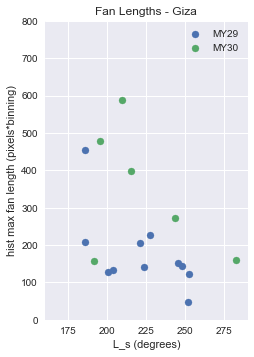

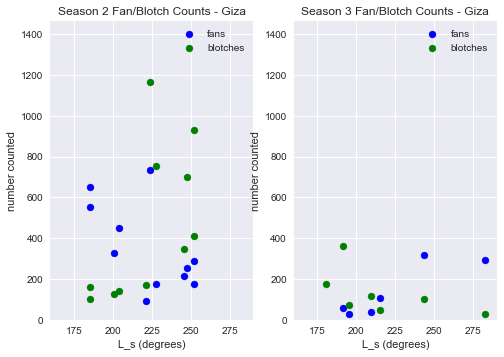

In [80]:
    n_fans_blot = np.concatenate((s2_nfans,s3_nfans,s2_nblot,s3_nblot),axis=0)
    histmax = np.concatenate((s2f_histmax,s3f_histmax),axis=0)
    
    plt.figure(i*2+1)
    plt.subplot(121)
    plt.title('Fan Lengths - {}'.format(regions[i][4]))
    plt.xlabel('L_s (degrees)')
    plt.ylabel('hist max fan length (pixels*binning)')
    plt.scatter(s2f_ls, s2f_histmax,label='MY29')
    plt.scatter(s3f_ls, s3f_histmax,label='MY30')
    plt.xlim((160,290))
    plt.ylim((0,800))
    plt.legend()
    #plt.subplot(122)
    #plt.title('Season 3 Fan Lengths - {}'.format(regions[i][4]))
    #plt.xlabel('L_s (degrees)')
    #plt.ylabel('hist max fan length (pixels*binning)')
    #plt.scatter(s3f_ls, s3f_histmax)
    #plt.xlim((160,290))
    #plt.ylim((0,max(histmax)+100))
    plt.figure(i*2+2)
    plt.subplot(121)
    plt.title('Season 2 Fan/Blotch Counts - {}'.format(regions[i][4]))
    plt.xlabel('L_s (degrees)')
    plt.ylabel('number counted')
    plt.scatter(s2f_ls, s2_nfans, label='fans', color='b')
    plt.scatter(s2f_ls, s2_nblot, label='blotches', color='g')
    plt.xlim((160,290))
    plt.ylim((0,max(n_fans_blot)+300))
    plt.legend()
    plt.subplot(122)
    plt.title('Season 3 Fan/Blotch Counts - {}'.format(regions[i][4]))
    plt.xlabel('L_s (degrees)')
    plt.ylabel('number counted')
    plt.scatter(s3f_ls, s3_nfans, label='fans', color='b')
    plt.scatter(s3b_ls, s3_nblot, label='blotches', color='g')
    plt.xlim((160,290))
    plt.ylim((0,max(n_fans_blot)+300))
    plt.legend()
    plt.show()